# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [3]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [13]:
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
api_key = getpass()

In [14]:
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=364)  # 1 year later

# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date:
    next_date = min(current_date + timedelta(days=7), end_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date + timedelta(days=1) #Incremented current_date by a day. Necessary to prevent overlap
    time.sleep(1)  # To avoid hitting the rate limit

# Now 'data' contains the NEO data for the 1-year period

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [4]:
# Check the date coverage of your data.
dates_contained_in_data = []
for d in data:
    dates_contained_in_data += list(d['near_earth_objects'].keys())

print(sorted(dates_contained_in_data))

KeyError: 'near_earth_objects'

In [120]:
from src.utils import get_a_random_chunk_property
get_a_random_chunk_property(data)

For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

In [8]:
#Save to pickle
import pickle
with open('NASAdata_raw.pkl', 'wb') as f:
    pickle.dump(data, f)

In [11]:
#Import from pickle
import pickle
with open('NASAdata_raw.pkl', 'rb') as f:
    data = pickle.load(f)

In [45]:
import pandas as pd
temp_dfs = []   #Create a temp list to store all the dataframe we are going to generate

for d in data:      #The way the data is saved to a list leaves it in pieces that we have to go over
    for day in d['near_earth_objects']:
        subset = d['near_earth_objects'][day]   #We take a subset consisting of all object logged that day
        df_temp = pd.json_normalize(subset)     #Turn the subset into a dataframe
        df_temp2 = pd.json_normalize(subset, record_path='close_approach_data') #Normalize doesn't catch close_approach_data for some reason, so we single that out too
        df_temp = pd.concat([df_temp, df_temp2], axis=1) #Combine the two temp dataframes
        df_temp = df_temp[['id',        #Retrieve the columns we want
                           'name',
                           'absolute_magnitude_h',
                           'estimated_diameter.meters.estimated_diameter_min', #meters
                           'estimated_diameter.meters.estimated_diameter_max', #meters
                           'is_potentially_hazardous_asteroid',
                           'close_approach_date_full',
                           'relative_velocity.kilometers_per_second',   #kilometers per second
                           'miss_distance.kilometers',      #kilometers
                           'orbiting_body',
                           'is_sentry_object']]
        df_temp.rename(columns={'estimated_diameter.meters.estimated_diameter_min': 'estimated_diameter_min (m)',
                                'estimated_diameter.meters.estimated_diameter_max': 'estimated_diameter_max (m)',
                                'relative_velocity.kilometers_per_second': 'relative_velocity (km/s)',
                                'miss_distance.kilometers': 'miss_distance (km)',
                                'is_potentially_hazardous_asteroid': 'potentially_hazardous'}, inplace=True)
        df_temp['date'] = day       #Save the date in a new column
        orderedColumns = ['date', 'id', 'name', 'absolute_magnitude_h', 'estimated_diameter_min (m)',
                          'estimated_diameter_max (m)', 'potentially_hazardous', 'close_approach_date_full',
                          'relative_velocity (km/s)', 'miss_distance (km)', 'orbiting_body', 'is_sentry_object']
        df_temp = df_temp.reindex(columns=orderedColumns)
        temp_dfs.append(df_temp)    #Save the dataframe in a temp list

df = pd.concat(temp_dfs, ignore_index=True)     #Combine all the saved dataframes
df

,date,id,name,absolute_magnitude_h,estimated_diameter_min (m),estimated_diameter_max (m),potentially_hazardous,close_approach_date_full,relative_velocity (km/s),miss_distance (km),orbiting_body,is_sentry_object
0,2022-01-07,2216523,216523 (2001 HY7),20.70,192.555078,430.566244,True,2022-Jan-07 06:54,13.0121883425,58057611.156145579,Earth,False
1,2022-01-07,2494697,494697 (2004 SW55),20.77,186.446818,416.907760,True,2022-Jan-07 12:09,10.0478001196,20026767.655944806,Earth,False
2,2022-01-07,2496860,496860 (1999 XL136),19.67,309.424699,691.894660,True,2022-Jan-07 02:07,16.7624360583,13396080.931113835,Earth,False
3,2022-01-07,3311963,(2006 AL4),24.92,27.577505,61.665176,False,2022-Jan-07 14:45,9.4579600698,14239203.68058826,Earth,False
4,2022-01-07,3401388,(2008 CO),22.60,80.270317,179.489885,False,2022-Jan-07 07:54,4.4645655825,30934770.472739391,Earth,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2669,2022-12-31,3989139,(2020 BW5),26.41,13.885291,31.048454,False,2022-Dec-31 09:41,6.2101753206,62348309.884604931,Earth,False
2670,2022-12-31,3989355,(2020 CB),27.70,7.665756,17.141151,False,2022-Dec-31 01:10,4.478349521,27830701.407084417,Earth,False
2671,2022-12-30,3367130,(2007 BB49),19.69,306.587876,685.551332,False,2022-Dec-30 16:05,8.225655557,55425577.809005498,Earth,False
2672,2022-12-30,3373981,(2007 HC),25.20,24.241248,54.205079,False,2022-Dec-30 10:50,7.8507811715,62027014.978776625,Earth,False


In [1]:
#Save to pickle
import pickle
with open('NASAdata_df.pkl', 'wb') as f:
    pickle.dump(df, f)

NameError: name 'df' is not defined

In [7]:
#Import from pickle
import pickle
with open('NASAdata_df.pkl', 'rb') as f:
    df = pickle.load(f)
df

,date,id,name,absolute_magnitude_h,estimated_diameter_min (m),estimated_diameter_max (m),potentially_hazardous,close_approach_date_full,relative_velocity (km/s),miss_distance (km),orbiting_body,is_sentry_object
0,2022-01-07,2216523,216523 (2001 HY7),20.70,192.555078,430.566244,True,2022-Jan-07 06:54,13.0121883425,58057611.156145579,Earth,False
1,2022-01-07,2494697,494697 (2004 SW55),20.77,186.446818,416.907760,True,2022-Jan-07 12:09,10.0478001196,20026767.655944806,Earth,False
2,2022-01-07,2496860,496860 (1999 XL136),19.67,309.424699,691.894660,True,2022-Jan-07 02:07,16.7624360583,13396080.931113835,Earth,False
3,2022-01-07,3311963,(2006 AL4),24.92,27.577505,61.665176,False,2022-Jan-07 14:45,9.4579600698,14239203.68058826,Earth,False
4,2022-01-07,3401388,(2008 CO),22.60,80.270317,179.489885,False,2022-Jan-07 07:54,4.4645655825,30934770.472739391,Earth,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2669,2022-12-31,3989139,(2020 BW5),26.41,13.885291,31.048454,False,2022-Dec-31 09:41,6.2101753206,62348309.884604931,Earth,False
2670,2022-12-31,3989355,(2020 CB),27.70,7.665756,17.141151,False,2022-Dec-31 01:10,4.478349521,27830701.407084417,Earth,False
2671,2022-12-30,3367130,(2007 BB49),19.69,306.587876,685.551332,False,2022-Dec-30 16:05,8.225655557,55425577.809005498,Earth,False
2672,2022-12-30,3373981,(2007 HC),25.20,24.241248,54.205079,False,2022-Dec-30 10:50,7.8507811715,62027014.978776625,Earth,False


### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

In [98]:
# Write your code

### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

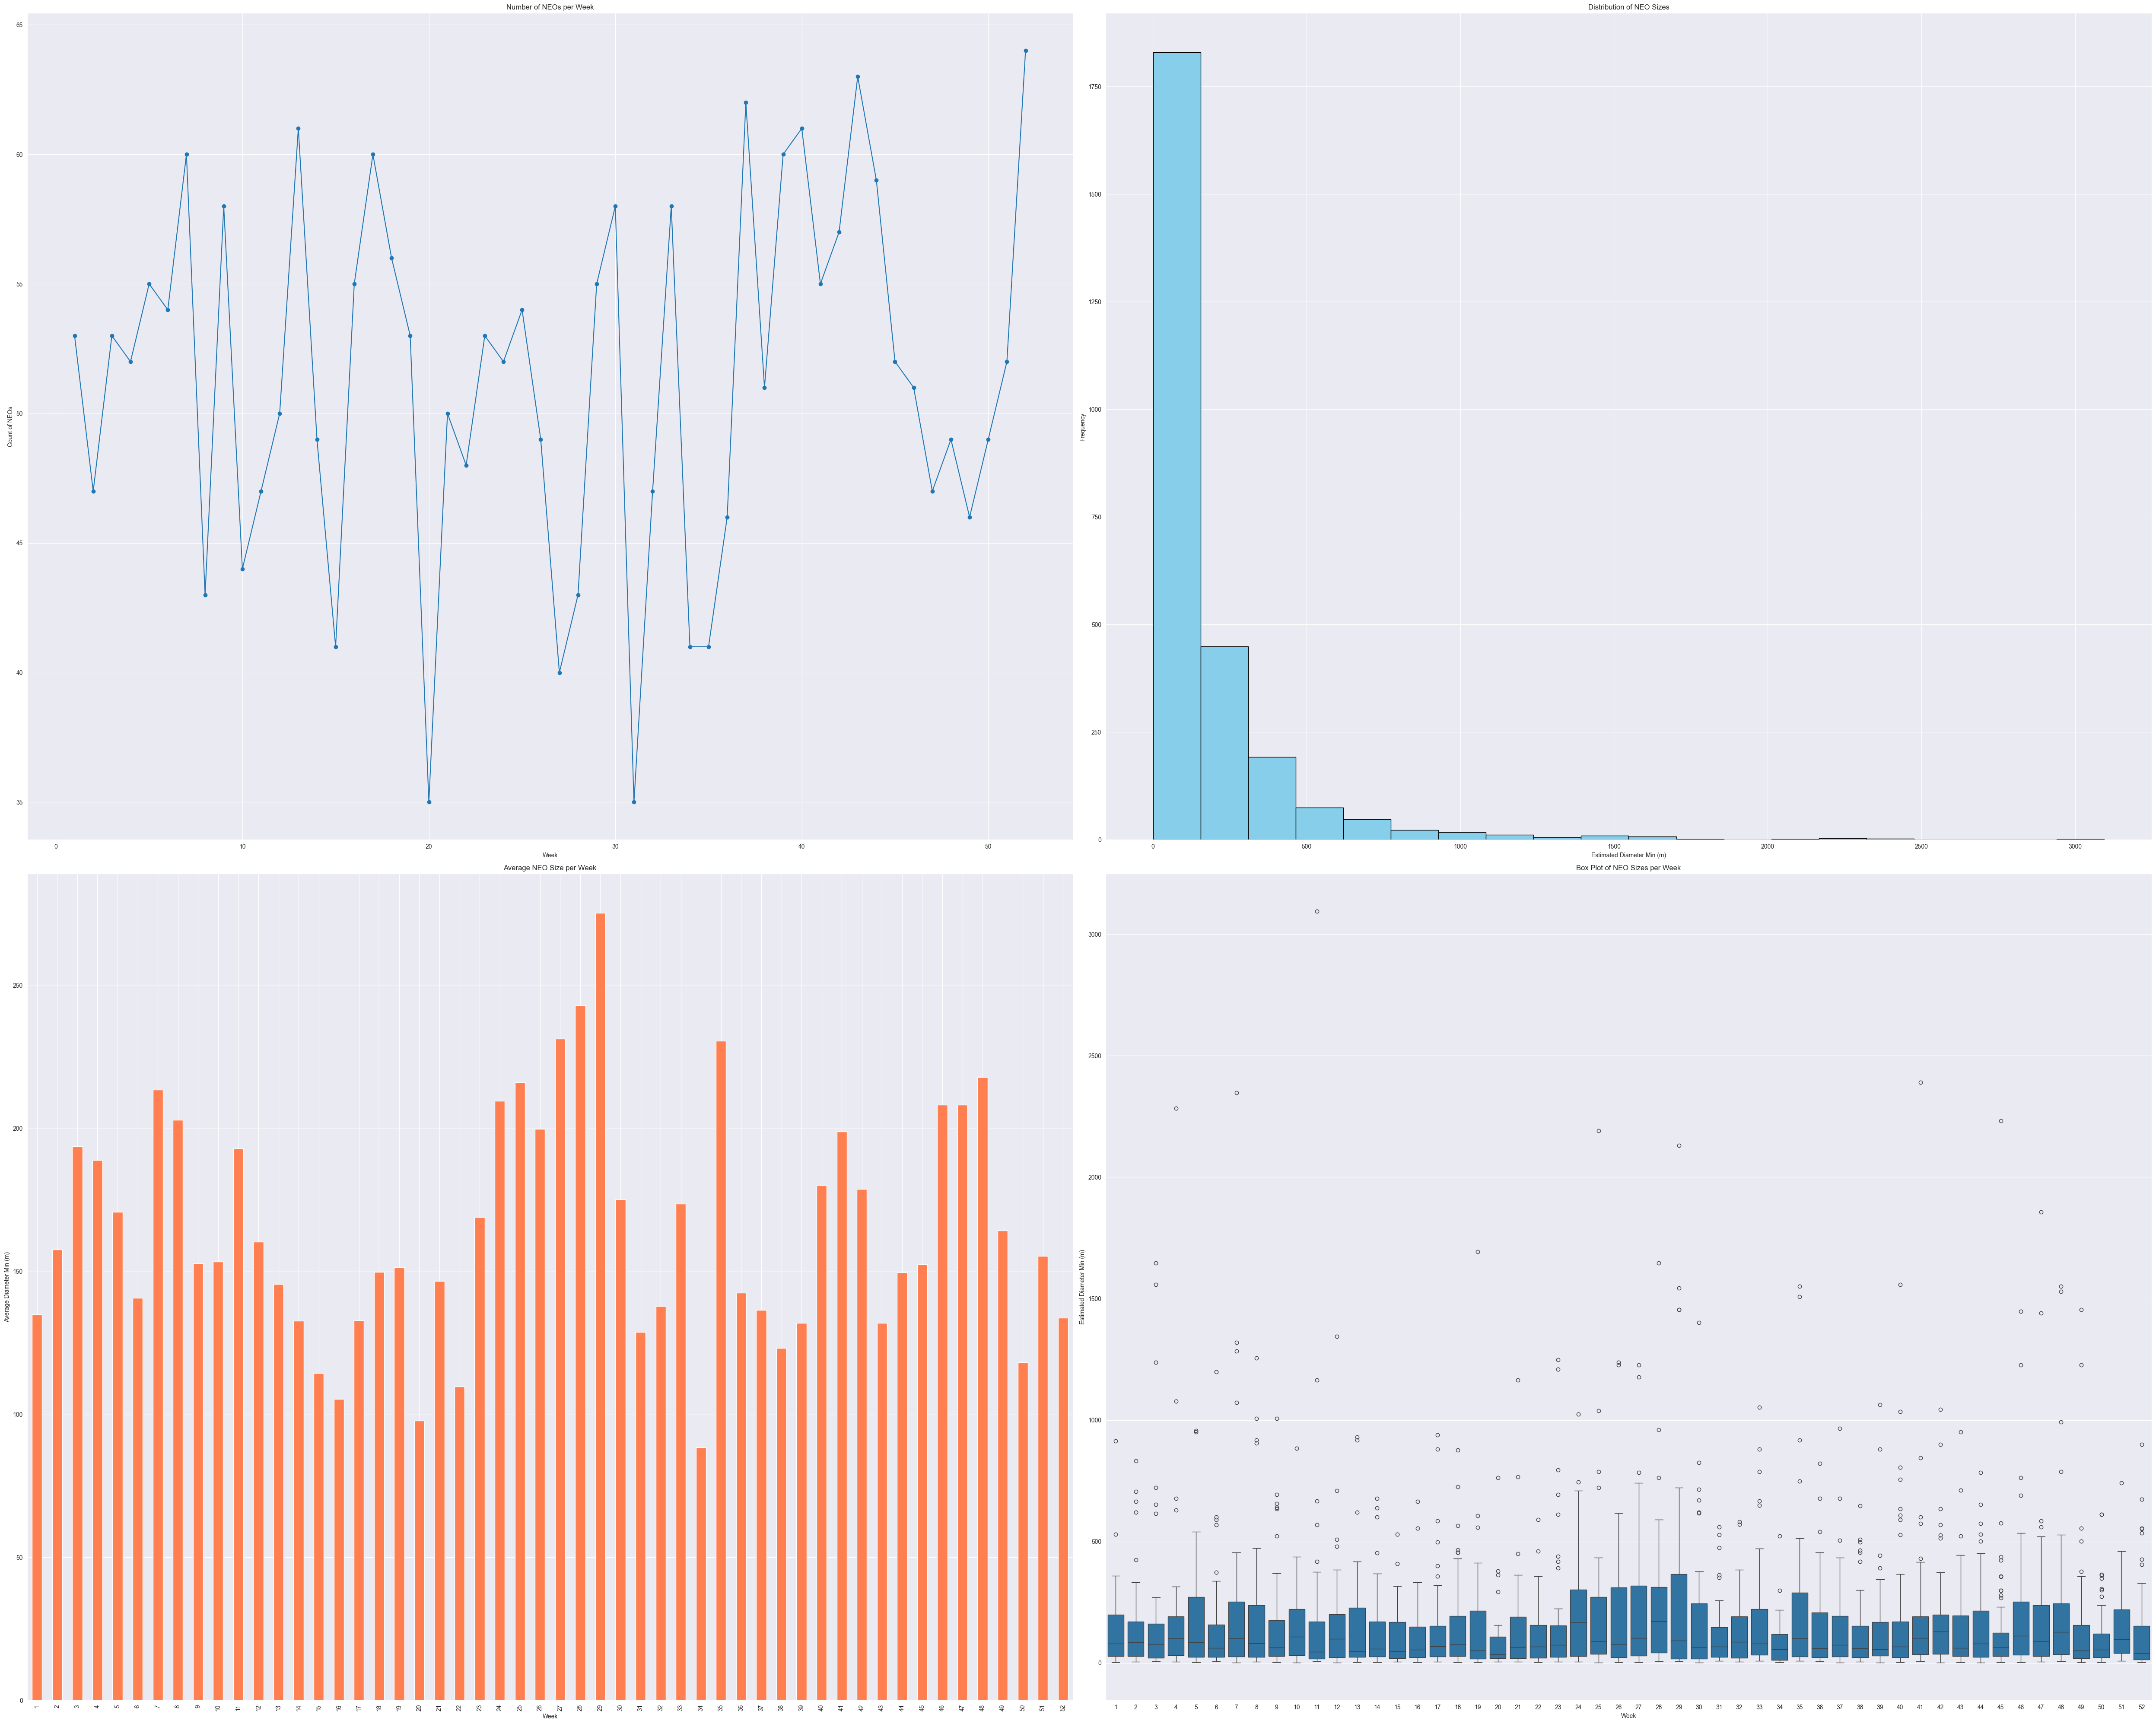

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import pickle

# Convert 'date' column to datetime and extract the week number
df['week'] = pd.to_datetime(df['close_approach_date_full']).dt.isocalendar().week

plt.figure(figsize=(40, 30))

# Group by 'week' and count unique 'id' for the number of NEOs per week
neos_per_week = df.groupby('week')['id'].nunique()

# Line plot for the number of NEOs per week
plt.subplot(2, 2, 1)
neos_per_week.plot(kind='line', marker='o')
plt.title('Number of NEOs per Week')
plt.xlabel('Week')
plt.ylabel('Count of NEOs')

# Histogram for the distribution of NEO sizes
sizes = df['estimated_diameter_min (m)']
plt.subplot(2, 2, 2)
plt.hist(sizes, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NEO Sizes')
plt.xlabel('Estimated Diameter Min (m)')
plt.ylabel('Frequency')

# Bar plot for the average NEO size per week
average_size_per_week = df.groupby('week')['estimated_diameter_min (m)'].mean()
plt.subplot(2, 2, 3)
average_size_per_week.plot(kind='bar', color='coral')
plt.title('Average NEO Size per Week')
plt.xlabel('Week')
plt.ylabel('Average Diameter Min (m)')

# Box plot of NEO sizes using Seaborn
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='week', y='estimated_diameter_min (m)')
plt.title('Box Plot of NEO Sizes per Week')
plt.xlabel('Week')
plt.ylabel('Estimated Diameter Min (m)')

# Adjust layout to prevent overlap and show plots
plt.tight_layout()
plt.show()


### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

In [99]:
# Write your code

### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In [ ]:
# Write your code

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.